<div align="center">

<h3>Predicting Forest Fires</h3>

<h3>**William Hahn**<h3>

<h3>**May 13, 2025**<h3>

</div>

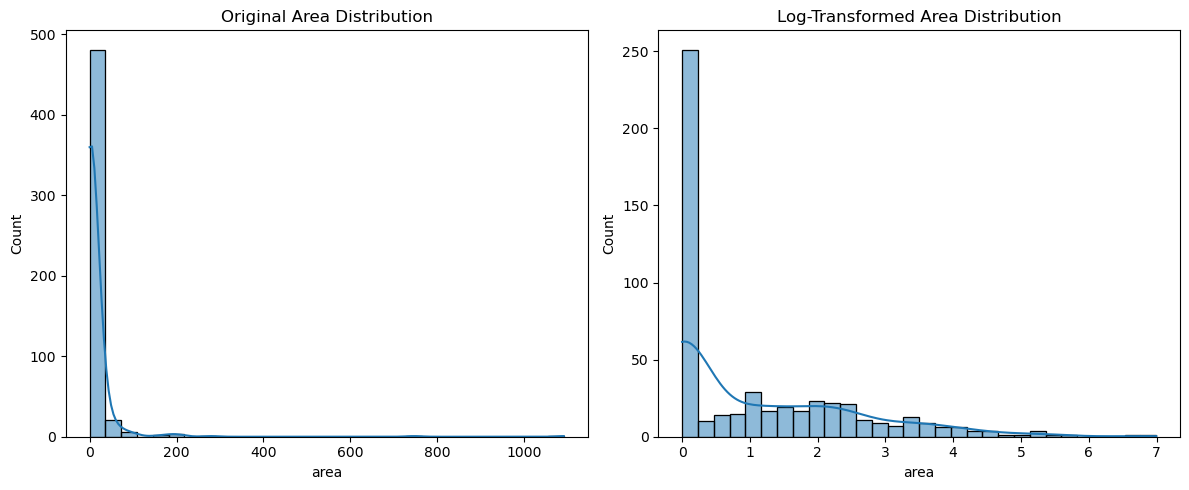


--- Untuned models on RAW target ---
                   Mean RMSE   Std RMSE   Mean R2
Linear Regression  40.884577  21.787281 -0.183589
Decision Tree      63.200770  20.426981 -4.752024
Random Forest      47.055108  19.954895 -0.899120
SVR                40.846172  23.080156 -0.100132

--- Untuned models on LOG-TRANSFORMED target ---
                   Mean RMSE  Std RMSE   Mean R2
Linear Regression   1.548826  0.241614 -0.438975
Decision Tree       1.901854  0.113323 -0.966131
Random Forest       1.510884  0.103124 -0.230445
SVR                 1.523915  0.156390 -0.244750

--- Tuned models on RAW target ---
Best params for Tuned Decision Tree (raw target): {'max_depth': 5, 'min_samples_split': 10}
Best params for Tuned Random Forest (raw target): {'max_depth': 5, 'n_estimators': 200}
Best params for Tuned SVR (raw target): {'C': 10, 'epsilon': 0.2, 'kernel': 'rbf'}
                     Mean RMSE   Std RMSE   Mean R2
Linear Regression    40.884577  21.787281 -0.183589
Tuned Decision

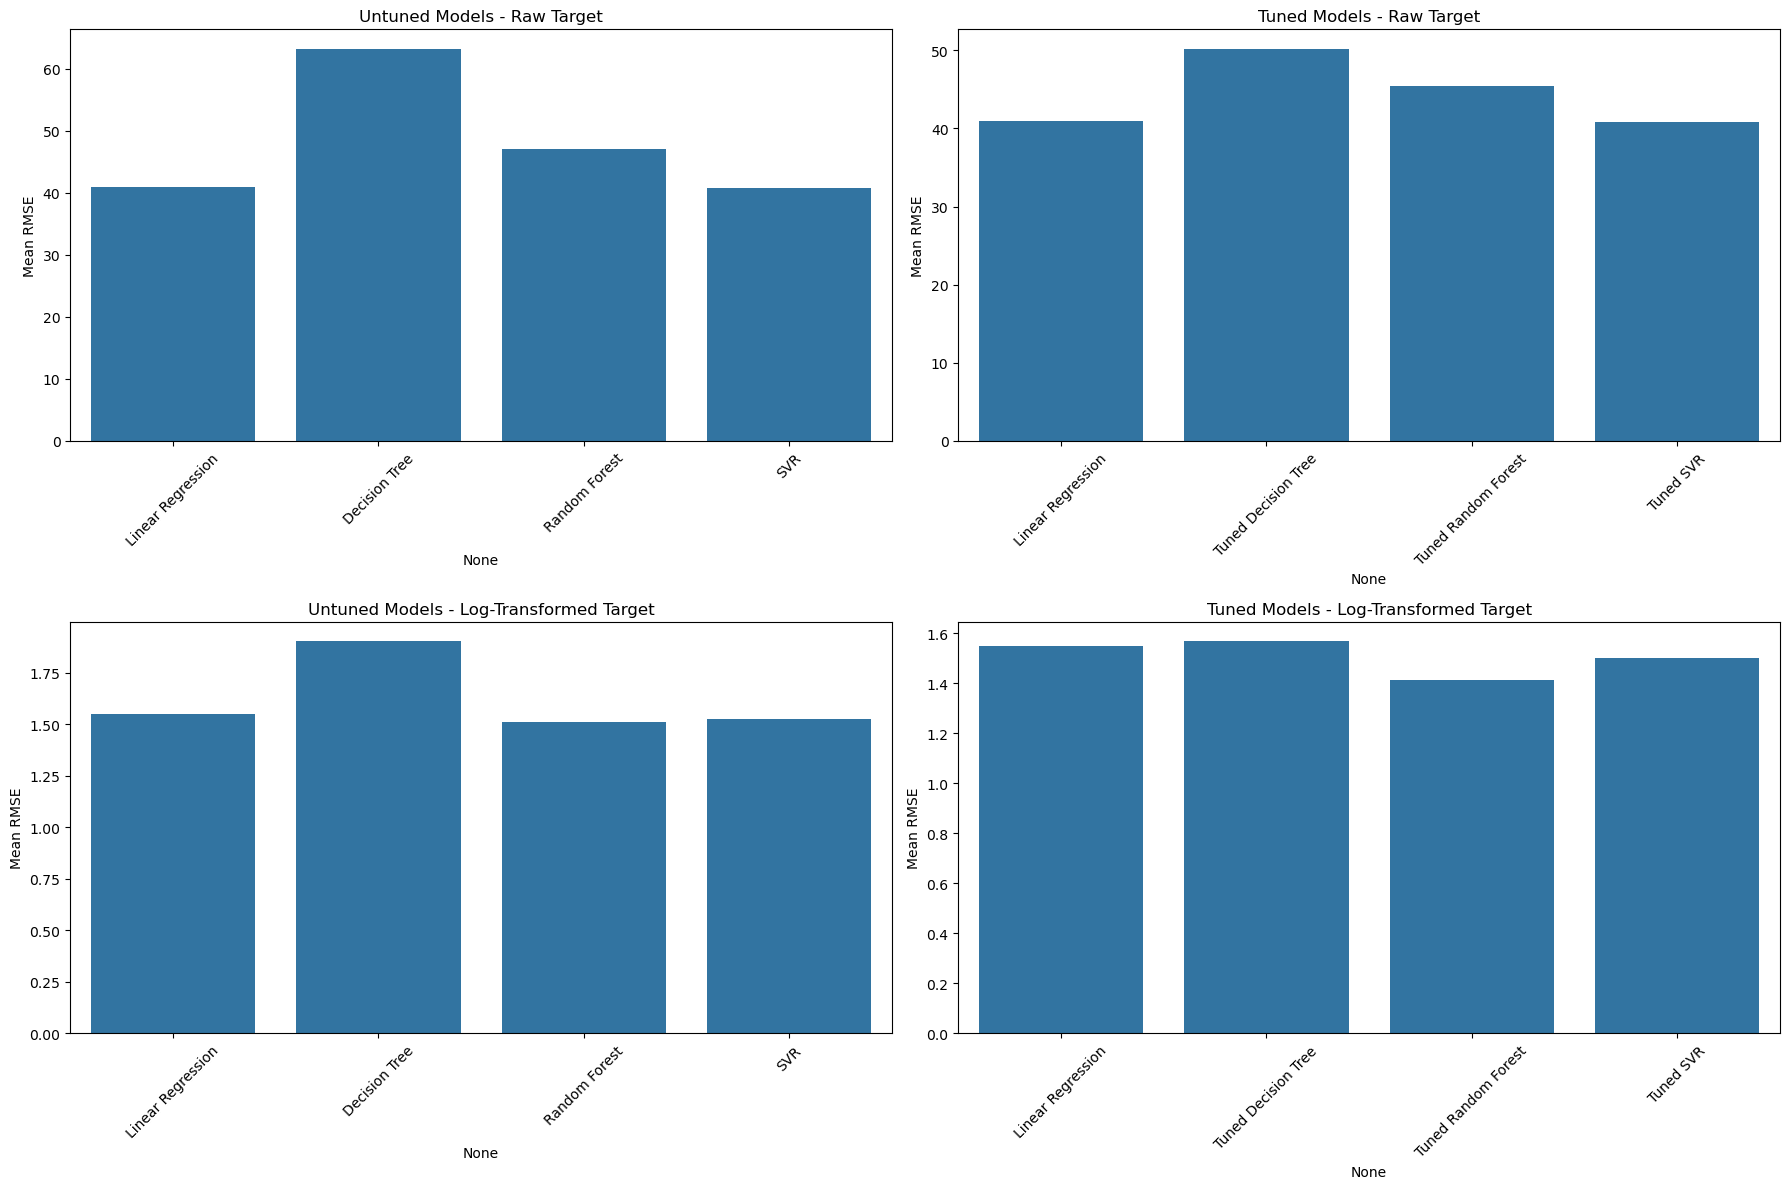


--- Scatter plots: Tuned Models on RAW target ---


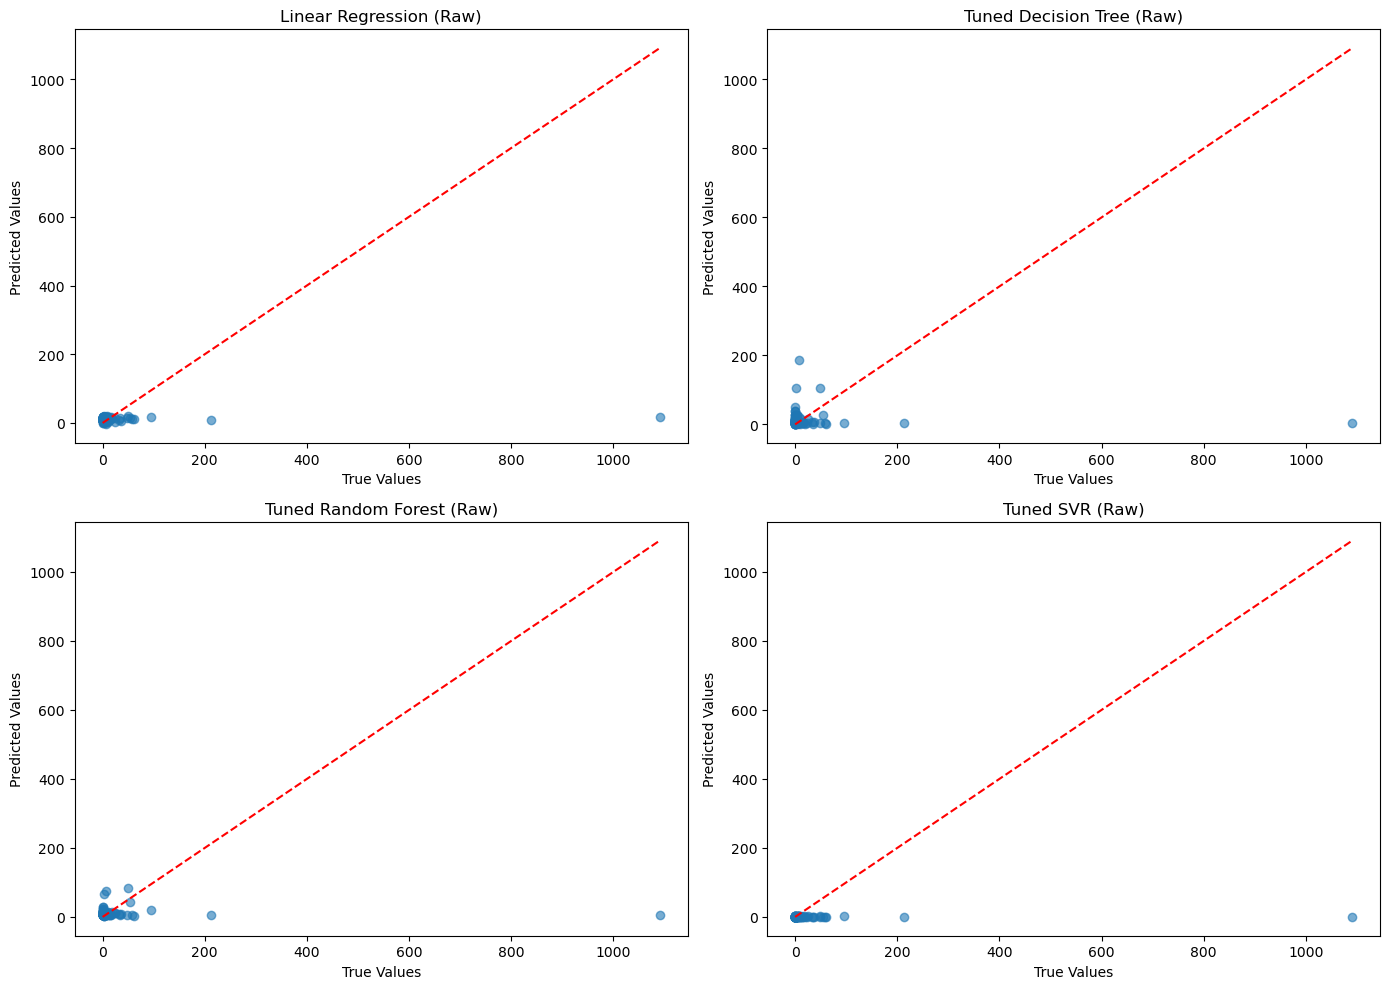


--- Scatter plots: Tuned Models on LOG-TRANSFORMED target ---


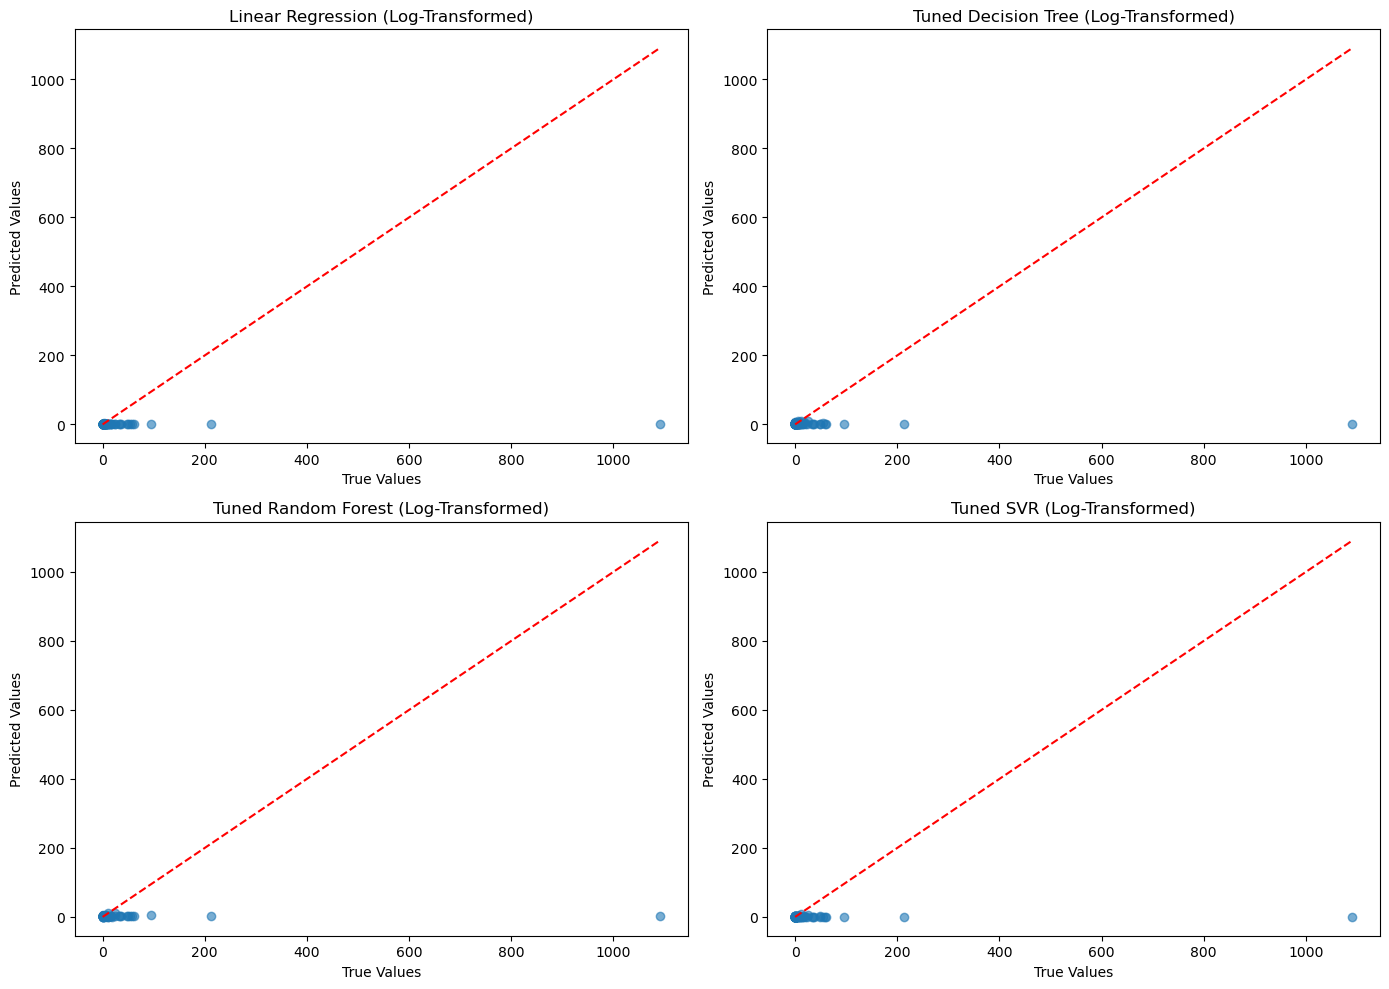

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error, r2_score

# ------------------------------
# Load the data
# ------------------------------
data = pd.read_csv('forestfires.csv')

# Select relevant features
features = ['temp', 'RH', 'wind', 'rain']
X = data[features]
y_raw = data['area']
y_log = np.log1p(y_raw)  # log(1 + area)

# ------------------------------
# Visualize distributions
# ------------------------------
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.histplot(y_raw, bins=30, kde=True)
plt.title('Original Area Distribution')

plt.subplot(1,2,2)
sns.histplot(y_log, bins=30, kde=True)
plt.title('Log-Transformed Area Distribution')

plt.tight_layout()
plt.show()

# ------------------------------
# Split into train/test sets
# ------------------------------
X_train, X_test, y_raw_train, y_raw_test = train_test_split(X, y_raw, test_size=0.2, random_state=42)
_, _, y_log_train, y_log_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

# ------------------------------
# Hyperparameter grids
# ------------------------------
param_grid_tree = {
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10]
}
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None]
}
param_grid_svr = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 0.2],
    'kernel': ['rbf']
}

# ------------------------------
# Functions
# ------------------------------

# Untuned models (evaluate + fit)
def evaluate_untuned(X, y):
    results = {}
    fitted_models = {}
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    models = {
        'Linear Regression': LinearRegression(),
        'Decision Tree': DecisionTreeRegressor(random_state=42),
        'Random Forest': RandomForestRegressor(random_state=42),
        'SVR': SVR()
    }

    for name, model in models.items():
        rmse_scores = -cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
        r2_scores = cross_val_score(model, X, y, scoring='r2', cv=cv, n_jobs=-1)

        results[name] = {
            'Mean RMSE': np.mean(rmse_scores),
            'Std RMSE': np.std(rmse_scores),
            'Mean R2': np.mean(r2_scores)
        }

        # Fit model fully
        model.fit(X, y)
        fitted_models[name] = model

    return pd.DataFrame(results).T, fitted_models

# Tuned models (evaluate + fit best)
def evaluate_tuned(X, y, is_log_target=True):
    results = {}
    fitted_models = {}
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    grid_tree = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid_tree, cv=cv,
                             scoring='neg_root_mean_squared_error', n_jobs=-1)
    grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=cv,
                           scoring='neg_root_mean_squared_error', n_jobs=-1)
    grid_svr = GridSearchCV(SVR(), param_grid_svr, cv=cv,
                            scoring='neg_root_mean_squared_error', n_jobs=-1)

    models = {
        'Linear Regression': LinearRegression(),
        'Tuned Decision Tree': grid_tree,
        'Tuned Random Forest': grid_rf,
        'Tuned SVR': grid_svr
    }

    for name, model in models.items():
        rmse_scores = -cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
        r2_scores = cross_val_score(model, X, y, scoring='r2', cv=cv, n_jobs=-1)

        results[name] = {
            'Mean RMSE': np.mean(rmse_scores),
            'Std RMSE': np.std(rmse_scores),
            'Mean R2': np.mean(r2_scores)
        }

        # Fit model fully
        model.fit(X, y)

        if isinstance(model, GridSearchCV):
            print(f"Best params for {name} ({'log' if is_log_target else 'raw'} target): {model.best_params_}")
            fitted_models[name] = model.best_estimator_
        else:
            fitted_models[name] = model

    return pd.DataFrame(results).T, fitted_models

# ------------------------------
# Evaluate models
# ------------------------------

# Untuned Models
print("\n--- Untuned models on RAW target ---")
results_untuned_raw, models_untuned_raw = evaluate_untuned(X_train, y_raw_train)
print(results_untuned_raw)

print("\n--- Untuned models on LOG-TRANSFORMED target ---")
results_untuned_log, models_untuned_log = evaluate_untuned(X_train, y_log_train)
print(results_untuned_log)

# Tuned Models
print("\n--- Tuned models on RAW target ---")
results_tuned_raw, models_tuned_raw = evaluate_tuned(X_train, y_raw_train, is_log_target=False)
print(results_tuned_raw)

print("\n--- Tuned models on LOG-TRANSFORMED target ---")
results_tuned_log, models_tuned_log = evaluate_tuned(X_train, y_log_train, is_log_target=True)
print(results_tuned_log)

# ------------------------------
# Visualize RMSE Comparison
# ------------------------------
fig, axes = plt.subplots(2, 2, figsize=(18,12))

sns.barplot(x=results_untuned_raw.index, y='Mean RMSE', data=results_untuned_raw, ax=axes[0,0])
axes[0,0].set_title('Untuned Models - Raw Target')
axes[0,0].tick_params(axis='x', rotation=45)

sns.barplot(x=results_tuned_raw.index, y='Mean RMSE', data=results_tuned_raw, ax=axes[0,1])
axes[0,1].set_title('Tuned Models - Raw Target')
axes[0,1].tick_params(axis='x', rotation=45)

sns.barplot(x=results_untuned_log.index, y='Mean RMSE', data=results_untuned_log, ax=axes[1,0])
axes[1,0].set_title('Untuned Models - Log-Transformed Target')
axes[1,0].tick_params(axis='x', rotation=45)

sns.barplot(x=results_tuned_log.index, y='Mean RMSE', data=results_tuned_log, ax=axes[1,1])
axes[1,1].set_title('Tuned Models - Log-Transformed Target')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# ------------------------------
# Scatter plots of Fitted Models
# ------------------------------

def plot_predictions(models, X_test, y_test, title_suffix=''):
    n_models = len(models)
    n_cols = 2
    n_rows = (n_models + 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 5 * n_rows))

    if n_rows == 1:
        axes = np.array([axes])

    for ax, (name, model) in zip(axes.flatten(), models.items()):
        # Predict
        y_pred = model.predict(X_test)

        # Scatter plot
        ax.scatter(y_test, y_pred, alpha=0.6)
        ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # perfect prediction line
        ax.set_xlabel('True Values')
        ax.set_ylabel('Predicted Values')
        ax.set_title(f'{name} {title_suffix}')

    plt.tight_layout()
    plt.show()

# ----------------------------------
# Plot for raw target (no log)
# ----------------------------------
print("\n--- Scatter plots: Tuned Models on RAW target ---")
plot_predictions(models_tuned_raw, X_test, y_raw_test, title_suffix='(Raw)')

# ----------------------------------
# Plot for log-transformed target
# (remember to reverse log1p!)
# ----------------------------------
print("\n--- Scatter plots: Tuned Models on LOG-TRANSFORMED target ---")

# Predict and inverse-transform
models_log_reversed = {}
for name, model in models_tuned_log.items():
    models_log_reversed[name] = lambda X, m=model: np.expm1(m.predict(X))  # reverse log1p safely

def plot_log_predictions(models, X_test, y_test, title_suffix=''):
    n_models = len(models)
    n_cols = 2
    n_rows = (n_models + 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 5 * n_rows))

    if n_rows == 1:
        axes = np.array([axes])

    for ax, (name, predict_func) in zip(axes.flatten(), models.items()):
        y_pred = predict_func(X_test)

        ax.scatter(y_test, y_pred, alpha=0.6)
        ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        ax.set_xlabel('True Values')
        ax.set_ylabel('Predicted Values')
        ax.set_title(f'{name} {title_suffix}')

    plt.tight_layout()
    plt.show()

plot_log_predictions(models_log_reversed, X_test, y_raw_test, title_suffix='(Log-Transformed)')
